In [1]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, MaxNLocator

_ = torch.manual_seed(42)

# Helper functions

In [2]:
def showimg(img, ax=None, shape=(28, 28), cmap='plasma', title="", fontsize=15, axis=False, savefig=False, filename=None):
    if ax is None: _, ax = plt.subplots()
    if not axis: ax.axis('off')
        
    img = img.reshape(shape)
    ax.imshow(img, cmap=cmap)
    ax.set_title(title, fontsize=fontsize)
    
    if savefig and filename is not None: plt.savefig(f"{filename}.png")

In [3]:
def showimgpanel(imgs, n_imgs, panelshape, figsize=None, 
                 labels=None, labels_prefix="Label : ",
                 title="", fontsize_title=30, fontsize_label=15, 
                 savefig=False, filename=None):
    if figsize is None: figsize = (panelshape[1] * 5, panelshape[0] * 5)
    
    x,y = panelshape
    n_imgs = min(imgs.shape[0], n_imgs, x*y)
    
    fig = plt.figure(figsize = figsize)
    fig.suptitle(title, fontsize = fontsize_title)
    fig.subplots_adjust(wspace=0.1, hspace=0.2)
    
    for i in range(n_imgs):
        ax = fig.add_subplot(x, y, i+1)
        img = imgs[i]
        
        if labels is None: label = ''
        else: label = labels_prefix + str(int(labels[i]))
        
        showimg(img, ax, title=label, fontsize=fontsize_label, savefig=False)            
        
    if savefig and filename is not None: plt.savefig(f"{filename}.png")

In [4]:
def saveModel(model, model_name, date=True):    
    if date: filename = f'../models/{model_name}_{datetime.now().strftime("%Y_%m_%d__%H_%M")})'
    else: filename = f'../models/{model_name}'
    
    torch.save(model.state_dict(), filename)

In [5]:
def loadModel(model, model_name):
    model.load_state_dict(torch.load(f'../models/{model_name}'))
    model.eval()
    return model

In [6]:
def divideInBatches(dataset, batch_size):
    # Train set
    n_batches = np.ceil(len(dataset)/batch_size)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return loader, n_batches,

In [7]:
def chooseDevice():
    device = ""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("GPU available via cuda")
    else:
        device = torch.device("cpu")
        print("GPU not available, CPU available")
    return device

In [8]:
device = chooseDevice()

GPU available via cuda


# Load dataset
We use the fashion MNIST dataset downloaded using the torchvision.datasets module.
The idea is the to create a label specifics custom datasets. With theses datasets we are going to train label specific GAN.

We use these datasets to define data_loaders

In [9]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

test_set = torchvision.datasets.FashionMNIST(root="../data/", train=False, download=True, transform=transform)
test_set_size = len(test_set)

train_set = torchvision.datasets.FashionMNIST(root="../data/", train=True, download=True, transform=transform)
train_set_size = len(train_set)

In [10]:
n_classes = len(train_set.classes)

In [11]:
train_sets = []
test_sets = []
for i in range(n_classes):
    idx = train_set.targets==i
    set_data = train_set.data[idx].float()
    set_data /= set_data.max() - set_data.min()
    set_data = 2. * set_data - 1.
    set_labels = train_set.targets[idx]
    train_sets.append(TensorDataset(set_data, set_labels))
    del set_data, set_labels
    
    idx = test_set.targets==i
    set_data = test_set.data[idx].float()
    set_data /= set_data.max() - set_data.min()
    set_data = 2. * set_data - 1.
    set_labels = test_set.targets[idx]
    test_sets.append(TensorDataset(set_data, set_labels))
    del set_data, set_labels

In [12]:
batch_size = 64

In [13]:
test_batches  = [divideInBatches(test_sets[i], batch_size)
                 for i in range(n_classes)]
train_batches = [divideInBatches(train_sets[i], batch_size)
                 for i in range(n_classes)]

# Models definition
We are using, for the GAN, the models architectures defined in the third homework.
The main reason is to evaluate if it is performing as well on the FashionMNIST dataset than it is on the regular MNIST.

As the two datasets are grayscale 28x28 pixels images, the architecture should work perfectly fine.

The idea here is to be able to predict with full certainty what the output of the GAN will be. To do so, we are training one GAN per class of the fashion MNIST dataset.

It will also provide better fitting on the data as we only need to generate one class.

In [14]:
class Generator(nn.Module):

    def __init__(self, dim_latent_space):
        super().__init__()
        self.dim_latent_space = dim_latent_space
        self.fc = nn.Linear(self.dim_latent_space, 64*7*7)
        self.trans_conv1 = nn.ConvTranspose2d(64, 64, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.trans_conv2 = nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 1, padding = 1)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.trans_conv3 = nn.ConvTranspose2d(32, 16, kernel_size = 3, stride = 1, padding = 1)
        self.batch_norm3 = nn.BatchNorm2d(16)
        self.trans_conv4 = nn.ConvTranspose2d(16, 1, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        
    def forward(self, x):                   # Input = batch_size*dim_latent_space
        x = self.fc(x)                      # Output = batch_size*(64*7*7)
        x = x.view(-1, 64, 7, 7)            # Output = batch_size*64*7*7
        x = self.trans_conv1(x)             # Output = batch_size*64*14*14
        x = F.relu(self.batch_norm1(x))
        x = self.trans_conv2(x)             # Output = batch_size*32*14*14
        x = F.relu(self.batch_norm2(x))
        x = self.trans_conv3(x)             # Output = batch_size*16*14*14
        x = F.relu(self.batch_norm3(x))     
        x = self.trans_conv4(x)             # Output = batch_size*1*28*28
        x = torch.tanh(x)
        return x

In [15]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(1, 32, kernel_size = 3, stride = 2, padding = 1)     
        self.conv0_drop = nn.Dropout2d(0.25)
        self.conv1 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv1_drop = nn.Dropout2d(0.25)
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_drop = nn.Dropout2d(0.25)
        self.conv3 = nn.Conv2d(128, 128, kernel_size = 3, stride = 2, padding = 1)
        self.conv3_drop = nn.Dropout2d(0.25)
        self.fc = nn.Linear(128*7*7, 1)
    
    def forward(self, x):                               # Input = batch_size*1*28*28
        x = x.view(-1, 1, 28, 28)                       # Output = batch_size*1*28*28
        x = F.leaky_relu(self.conv0(x), 0.2)            # Output = batch_size*32*14*14
        x = self.conv0_drop(x)
        x = F.leaky_relu(self.conv1(x), 0.2)            # Output = batch_size*64*14*14
        x = self.conv1_drop(x)
        x = F.leaky_relu(self.conv2(x), 0.2)            # Output = batch_size*128*14*14
        x = self.conv2_drop(x)
        x = F.leaky_relu(self.conv3(x), 0.2)            # Output = batch_size*128*7*7
        x = self.conv3_drop(x)
        x = x.view(-1, 128*7*7)                         # Output = batch_size*(128*7*7)
        x = self.fc(x)                                  # Output = batch_size*1
        return x

In [16]:
dim_latent_space = 100

In [17]:
generators = [Generator(dim_latent_space).to(device=device)
              for i in range(n_classes)]

In [18]:
discriminators = [Discriminator().to(device=device)
                  for i in range(n_classes)]

# Training the GAN

The same method is used for training and evaluating all models.
It will be used to iterate on all the datasets and GANs

In [19]:
n_epoch = 50

In [20]:
def computeGANAccuracy(y_predicted,y_true):
    y_temp = np.copy(y_predicted)
    
    y_temp[y_temp <= .5] = 0. # Fake image
    y_temp[y_temp >.5] = 1.   # Real image
    
    accuracy = (y_temp == y_true)
    accuracy = accuracy.astype(float)
    accuracy = np.sum(accuracy)/accuracy.size
    
    return accuracy

In [21]:
def evaluate_raw_performances(train_loarder, test_loader, n_batches_train, n_batches_test, batch_size,
                              generator, discriminator, 
                              loss_function, optimizer_gen, optimizer_disc,
                              accuracies_train, accuracies_test, losses_gen, losses_disc,
                              device, log=True):
    generator.eval()
    discriminator.eval()
    
    dim_latent_space = generator.dim_latent_space
    
    for batch_id, (real_data, _) in enumerate(train_loader):
        real_data = real_data.reshape((-1,1,28,28)).to(device)
        noise = torch.randn(batch_size, dim_latent_space).to(device)
        fake_data = generator(noise).to(device)
        
        disc_real = discriminator(real_data).to(device)
        disc_fake = discriminator(fake_data).to(device)
        
        # Expected accuray 50%
        accuracies_train[0] += 0.5 * computeGANAccuracy(disc_real.cpu().detach(), np.ones(disc_real.shape))
        accuracies_train[0] += 0.5 * computeGANAccuracy(disc_fake.cpu().detach(), np.zeros(disc_fake.shape))
        
        losses_disc_fake = loss_function(disc_fake, torch.zeros_like(disc_fake).to(device))
        losses_disc_real = loss_function(disc_real, torch.ones_like(disc_real).to(device))
        
        losses_disc[0] += 0.5 * (losses_disc_real + losses_disc_fake).to(device)
        losses_gen[0] += loss_function(disc_fake, torch.ones_like(disc_fake)).to(device)
    
    accuracies_train[0] /= n_batches_train
    losses_gen[0] /= n_batches_train
    losses_disc[0] /= n_batches_train
    
    for batch_id, (real_data, _) in enumerate(test_loader):
        noise = torch.randn(batch_size, dim_latent_space).to(device)
        fake_data = generator(noise).to(device)
        real_data = real_data.to(device)
        
        disc_real = discriminator(real_data).to(device)
        disc_face = discriminator(fake_data).to(device)
        
        # Expected accuray 1/n_classes if dataset is balanced
        accuracies_test[0] += 0.5 * computeGANAccuracy(disc_real.cpu().detach(), np.ones(disc_real.shape))
        accuracies_test[0] += 0.5 * computeGANAccuracy(disc_fake.cpu().detach(), np.zeros(disc_fake.shape))
    
    optimizer_gen.zero_grad()
    optimizer_disc.zero_grad()
    
    accuracies_test[0] /= n_batches_test
    
    if log:
        print("GAN performance before training\n")

        print(f"Accuracy of the discriminator during train: {accuracies_train[0] * 100:.2f}%")
        print(f"Accuracy of the discriminator during test:  {accuracies_test[0] * 100:.2f}%")
        print(f"Average discriminator loss during train: {losses_disc[0]:.2f}")
        print(f"Average generator loss during train: {losses_gen[0]:.2f}")

In [22]:
def train_gan(train_loarder, test_loader, n_batches_train, n_batches_test, batch_size,
              generator, discriminator, 
              loss_function, optimizer_gen, optimizer_disc,
              accuracies_train, accuracies_test, losses_gen, losses_disc,
              n_epoch, device, log=True):
    dim_latent_space = generator.dim_latent_space
    
    for epoch in range(n_epoch):
        # Training phase
        for batch_id, (real_data, _) in enumerate(train_loader):
            
            #############################
            #  Train the discriminator  #
            #############################
            
            discriminator.train()
            generator.eval()
            
            ## Discriminator input
            real_data = real_data.reshape((-1,1,28,28)).to(device)
            noise = torch.randn(batch_size, dim_latent_space).to(device) #Noise to feed the generator
            fake_data = generator(noise).to(device)
            
            ## Discriminator outpu
            disc_fake = discriminator(fake_data).to(device)
            disc_real = discriminator(real_data).to(device)
            
            ## Discriminator loss
            loss_disc_fake = loss_function(disc_fake, torch.zeros_like(disc_fake)).to(device)
            loss_disc_real = loss_function(disc_real, torch.ones_like(disc_real)).to(device)
            loss_disc = .5 * (loss_disc_fake + loss_disc_real)
            
            ## Discriminator optimization
            optimizer_disc.zero_grad()
            loss_disc.backward()
            optimizer_disc.step()
            
            ## Discriminator metrics
            losses_disc[epoch + 1] += loss_disc
            accuracies_train[epoch + 1] += 0.5 * computeGANAccuracy(disc_fake.cpu().detach(), np.zeros(disc_fake.shape))
            accuracies_train[epoch + 1] += 0.5 * computeGANAccuracy(disc_real.cpu().detach(), np.ones(disc_real.shape))
            
            discriminator.eval()
            
            #############################
            #    Train the generator    #
            #############################
            
            generator.train()
            
            ## Generator input/outpu
            noise = torch.randn(batch_size, dim_latent_space).to(device)
            fake_data = generator(noise).to(device)
            
            ## Discriminator output
            disc_fake = discriminator(fake_data).to(device)
            
            ## Generator loss
            loss_gen = loss_function(disc_fake, torch.ones_like(disc_fake)).to(device)
            
            ## Generator optimization
            optimizer_gen.zero_grad()
            loss_gen.backward()
            optimizer_gen.step()
            
            ## Generator metrics
            losses_gen[epoch + 1] += loss_gen
            
            #############################
            #         Train log         #
            #############################
            
            if log:
                if batch_id == 0:
                    print(f"Epoch [{epoch + 1:2d}/{n_epoch:2d}]   Batch {batch_id + 1:4d}/{len(train_loader)}   Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}")

                    s = f"Epoch [{epoch + 1:2d}/{n_epoch:2d}]"
                    s = " " * len(s)
                elif (batch_id%750 == 0) or (batch_id + 1 == len(train_loader)):
                    print(f"{s}   Batch {batch_id + 1:4d}/{len(train_loader)}   Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}")

        
        accuracies_train[epoch + 1] /= n_batches_train
        losses_gen[epoch + 1] /= n_batches_train
        losses_disc[epoch + 1] /= n_batches_train
        
        # Evaluation phase
        generator.eval()
        discriminator.eval()
        for batch_id, (real_data, _) in enumerate(test_loader):
            real_data = real_data.reshape((-1,1,28,28)).to(device)
            noise = torch.randn(batch_size, dim_latent_space).to(device)
            fake_data = generator(noise).to(device)
            
            disc_real = discriminator(real_data).to(device)
            disc_fake = discriminator(fake_data).to(device)
            
            accuracies_test[epoch+1] += 0.5 * computeGANAccuracy(disc_real.cpu().detach(), np.ones(disc_real.shape))
            accuracies_test[epoch+1] += 0.5 * computeGANAccuracy(disc_fake.cpu().detach(), np.zeros(disc_fake.shape))
        
        accuracies_test[epoch + 1] /= n_batches_test

In [23]:
loss_function = nn.BCEWithLogitsLoss()

lr_gan = 2e-4
betas_gan = (0.5, 0.999)

optimizers_discriminators = [torch.optim.Adam(discriminators[i].parameters(), lr=lr_gan, betas = betas_gan)
                            for i in range(n_classes)]
optimizers_generators = [torch.optim.Adam(generators[i].parameters(), lr=lr_gan, betas = betas_gan)
                        for i in range(n_classes)]

In [24]:
accuracies_trains = [np.zeros(n_epoch + 1) for i in range(n_classes)]
accuracies_tests  = [np.zeros(n_epoch + 1) for i in range(n_classes)]

losses_generators  = [np.zeros(n_epoch + 1) for i in range(n_classes)]
losses_discriminators = [np.zeros(n_epoch + 1) for i in range(n_classes)]

We are training all the GANs at once within a for loop

In [25]:
%%time
for i in range(n_classes):
    title = f"Training phase the GAN for class {i}: '{train_set.classes[i]}'"
    print(f"\n\n{title}\n{'-' * len(title)}\n{'-' * len(title)}\n\n")
    test_loader, test_n_batches = test_batches[i]
    train_loader, train_n_batches = train_batches[i]
    
    generator = generators[i]
    discriminator = discriminators[i]
    
    optimizer_discriminator = optimizers_discriminators[i]
    optimizer_generator = optimizers_generators[i]
    
    accuracies_train = accuracies_trains[i]
    accuracies_test = accuracies_tests[i]
    
    losses_discriminator = losses_discriminators[i]
    losses_generator = losses_generators[i]
    
    evaluate_raw_performances(train_loader, test_loader, train_n_batches, test_n_batches, batch_size,
                              generator, discriminator,
                              loss_function, optimizer_generator, optimizer_discriminator,
                              accuracies_train, accuracies_test, losses_generator, losses_discriminator,
                              device)
    title = "Training GAN"
    print(f"\n{title}\n{'-' * len(title)}\n")
    
    train_gan(train_loader, test_loader, train_n_batches, test_n_batches, batch_size,
              generator, discriminator,
              loss_function, optimizer_generator, optimizer_discriminator,
              accuracies_train, accuracies_test, losses_generator, losses_discriminator,
              n_epoch, device)

del title



Training phase the GAN for class 0: 'T-shirt/top'
-------------------------------------------------
-------------------------------------------------


GAN performance before training

Accuracy of the discriminator during train: 50.00%
Accuracy of the discriminator during test:  50.00%
Average discriminator loss during train: 0.69
Average generator loss during train: 0.70

Training GAN
------------

Epoch [ 1/50]   Batch    1/94   Loss D: 0.6911, loss G: 0.6836
                Batch   94/94   Loss D: 0.0274, loss G: 4.6647
Epoch [ 2/50]   Batch    1/94   Loss D: 0.0656, loss G: 4.2553
                Batch   94/94   Loss D: 0.0623, loss G: 4.2885
Epoch [ 3/50]   Batch    1/94   Loss D: 0.1163, loss G: 3.9061
                Batch   94/94   Loss D: 0.1656, loss G: 4.0339
Epoch [ 4/50]   Batch    1/94   Loss D: 0.1489, loss G: 4.5583
                Batch   94/94   Loss D: 0.1920, loss G: 3.4739
Epoch [ 5/50]   Batch    1/94   Loss D: 0.2155, loss G: 4.5635
                Batch   94/9

In [26]:
torch.cuda.empty_cache() 

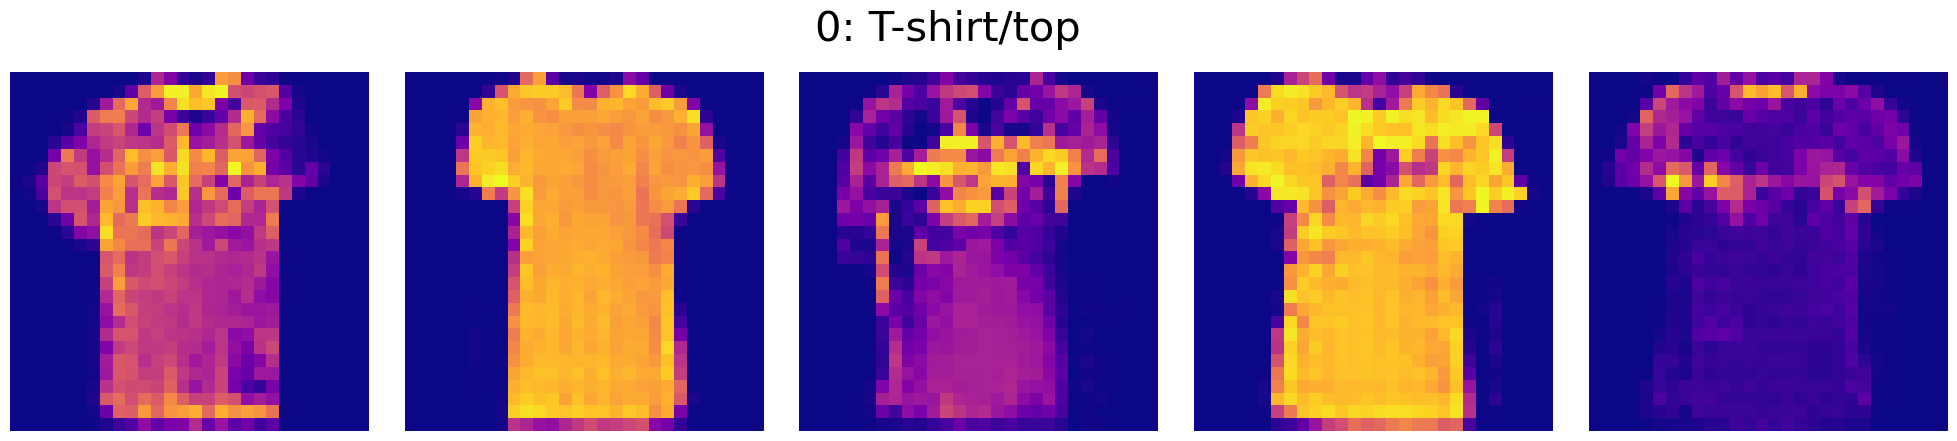

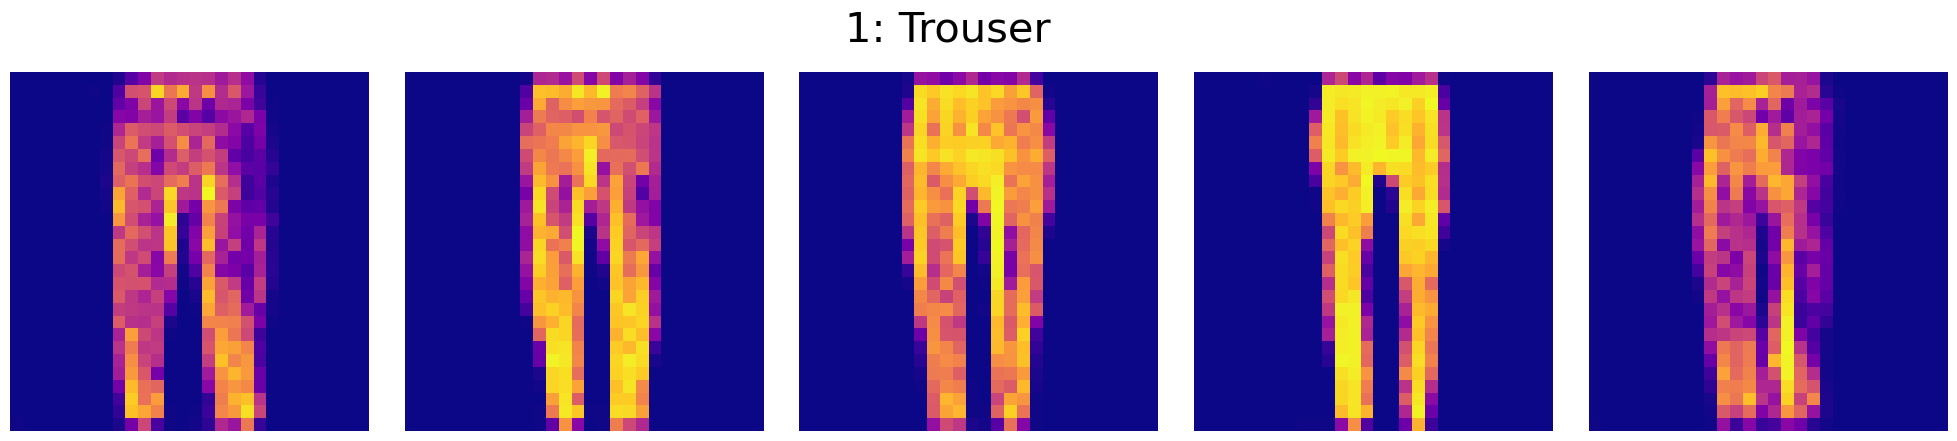

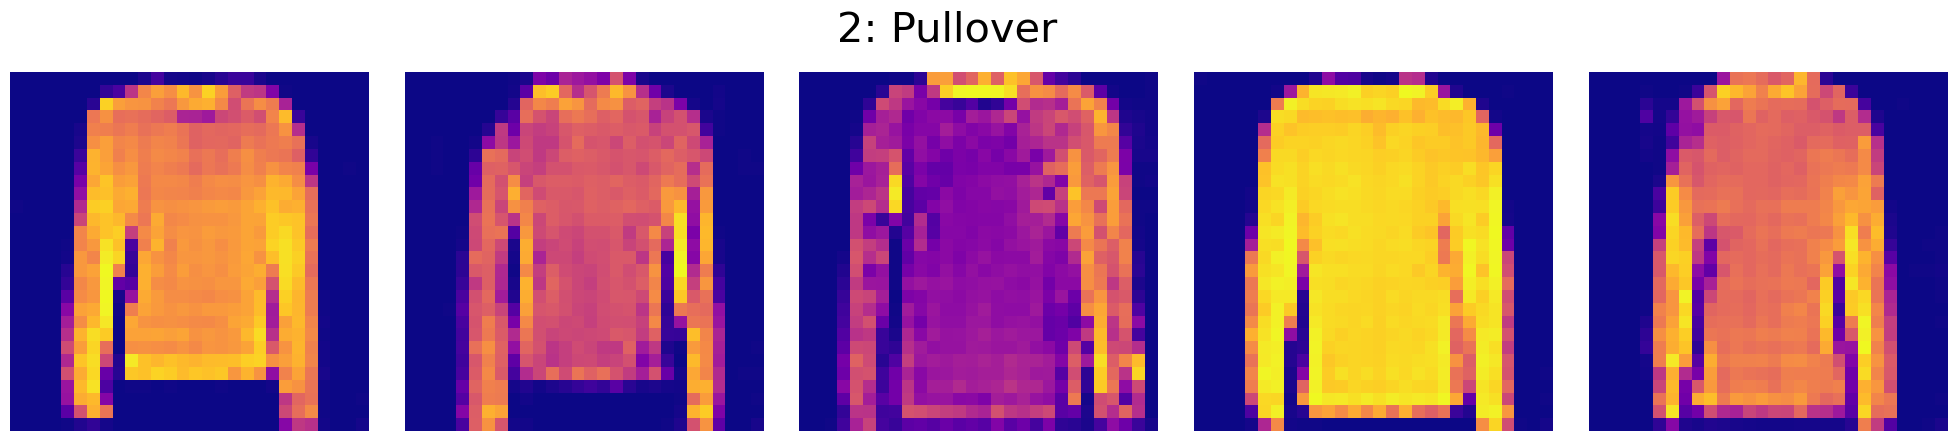

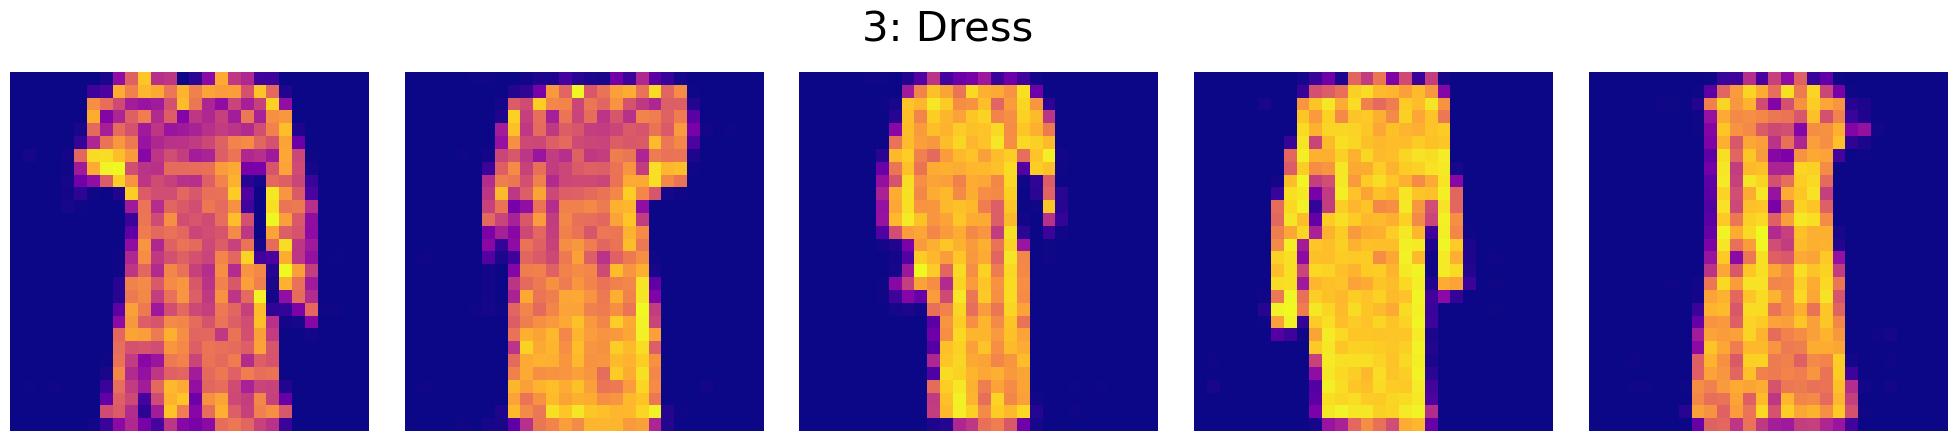

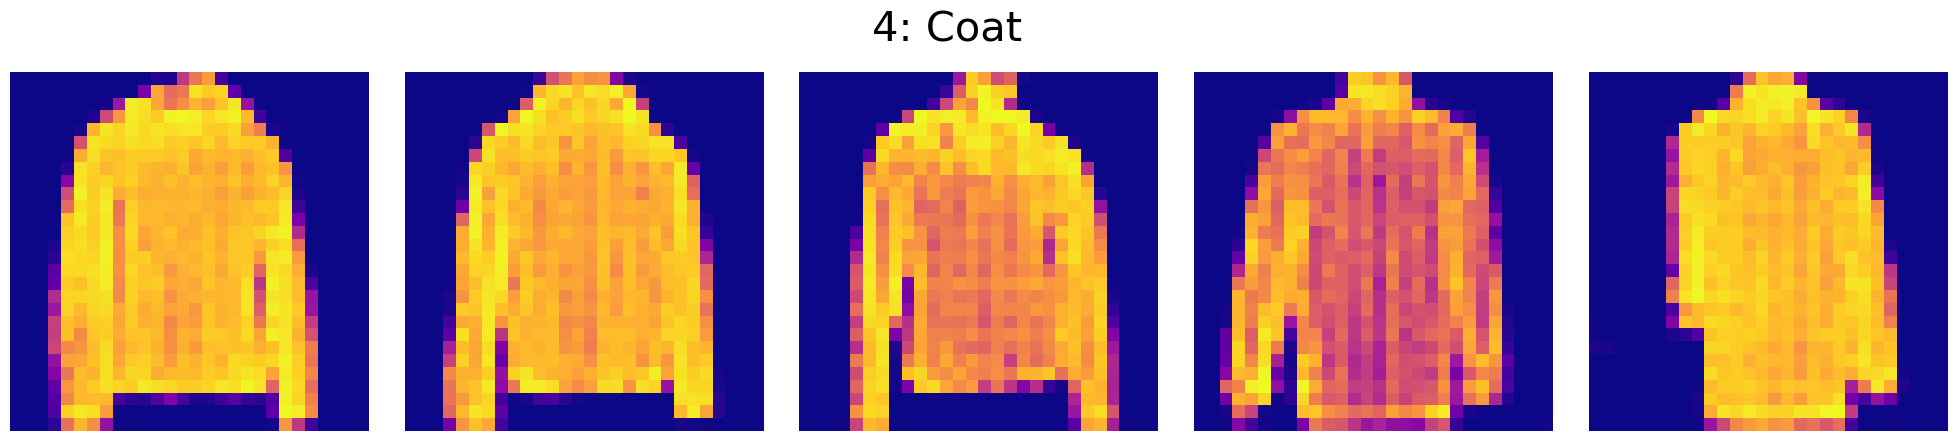

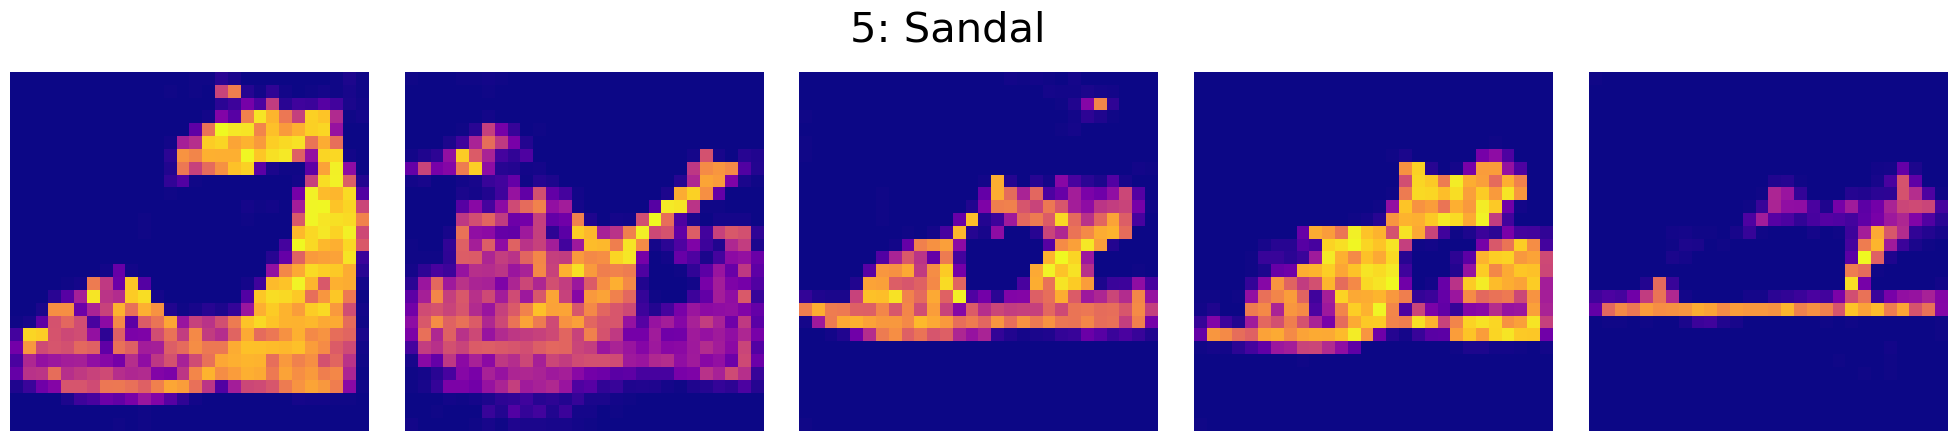

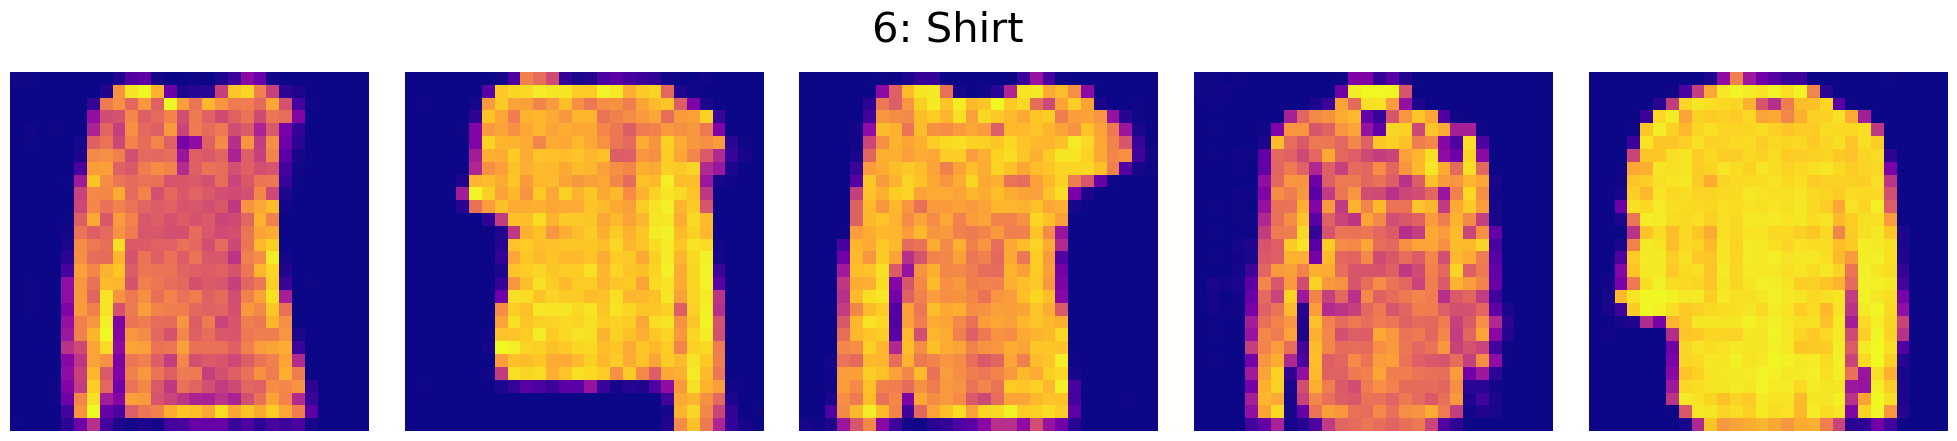

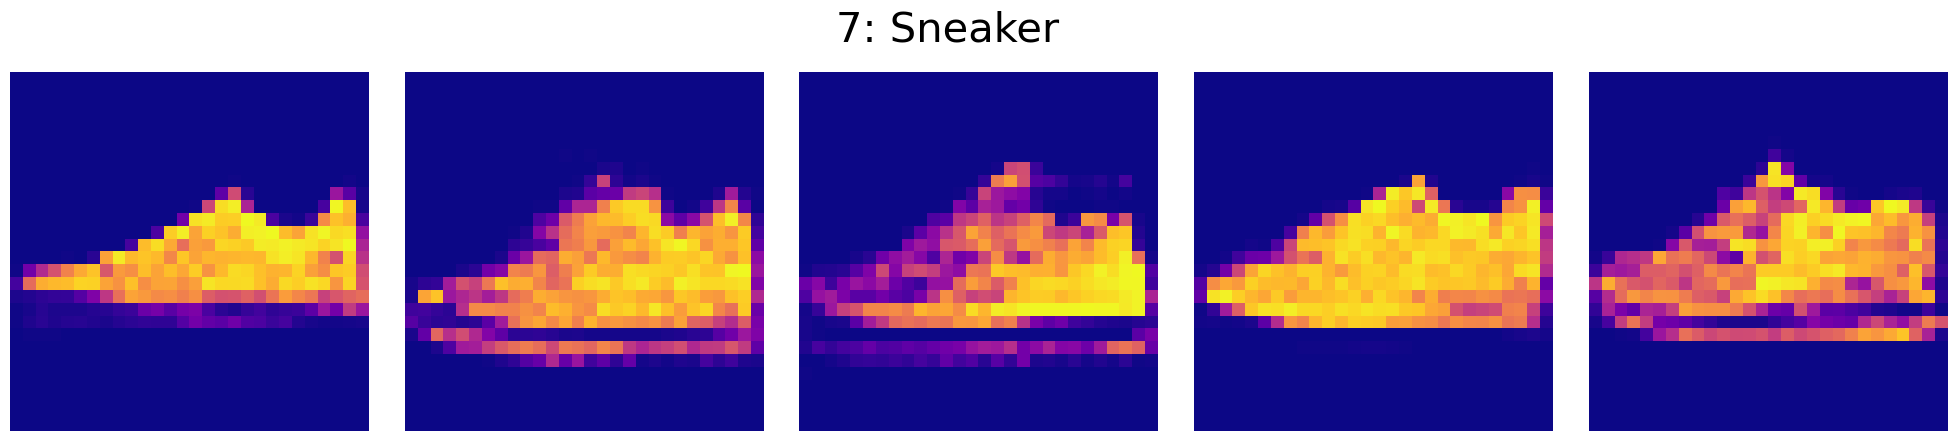

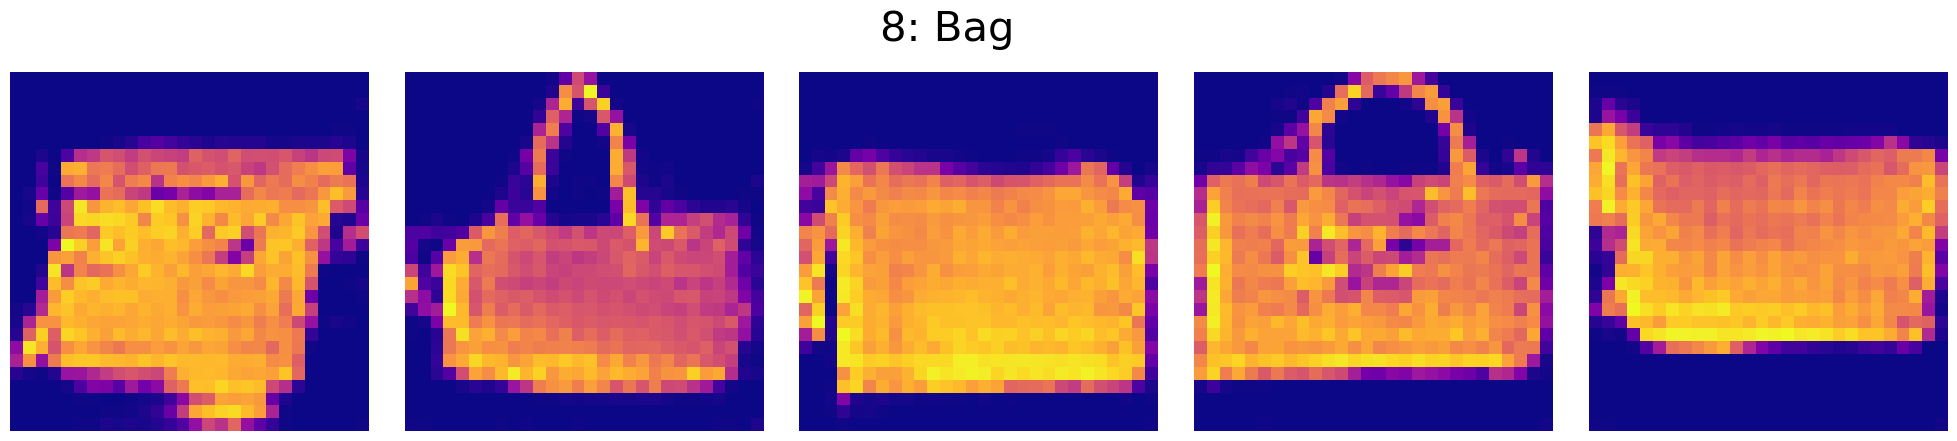

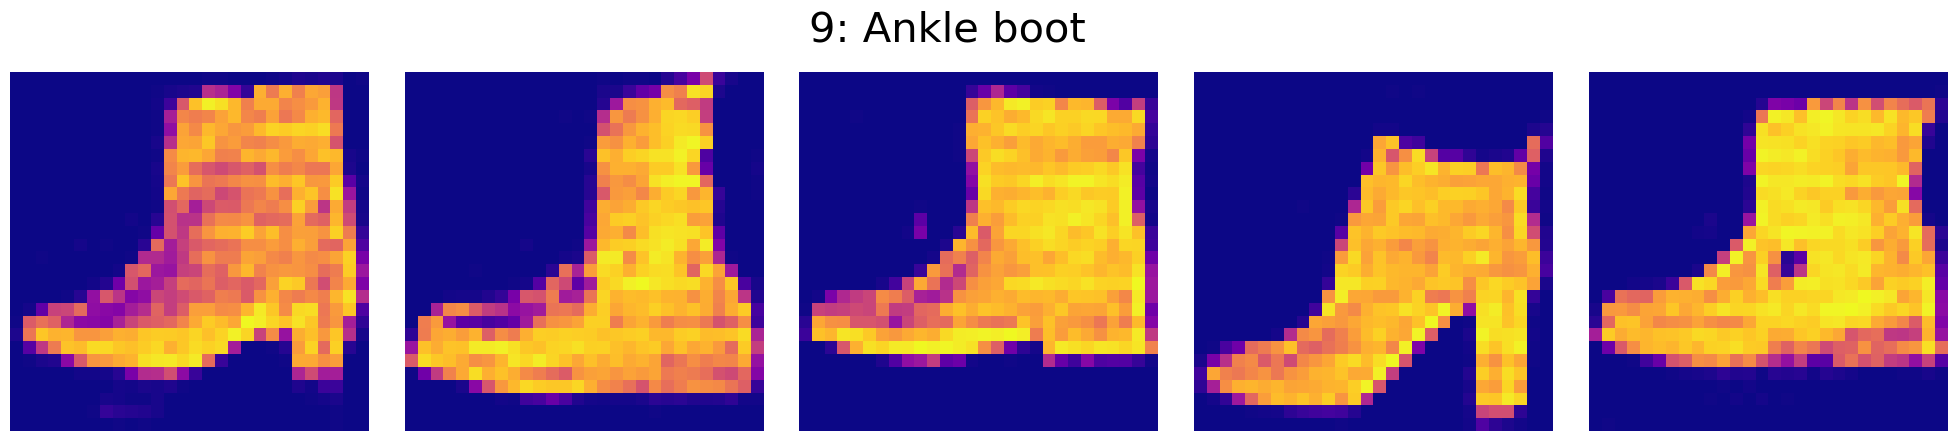

In [27]:
for i in range(n_classes):
    generator = generators[i]
    noise = torch.randn(5, dim_latent_space).to(device)
    imgs = generator(noise).cpu().detach()
    showimgpanel(imgs, 5, (1,5), title=f"{i}: {train_set.classes[i]}",savefig=True, filename=f'../figures/GAN_{n_epoch}_class_{i}')